In [6]:
%config InlineBackend.figure_format = 'retina'

In [7]:
import numpyro
numpyro.set_host_device_count(2)

In [8]:
import scipy.signal as ssig
import lalsimulation as lalsim 
import numpy as np
import jax.numpy as jnp
import jax
import arviz as az
import corner

import matplotlib.pyplot as plt
from ripple.waveforms.IMRPhenomD import gen_IMRPhenomD
from ripple import ms_to_Mc_eta

### First lets look at generating some noise with lalsim (from Max's notebook)

In [9]:
psd_func_dict = {
    'H1': lalsim.SimNoisePSDaLIGOZeroDetHighPower,
    'L1': lalsim.SimNoisePSDaLIGOZeroDetHighPower,
    'V1': lalsim.SimNoisePSDAdvVirgo,
}
ifos = list(psd_func_dict.keys())

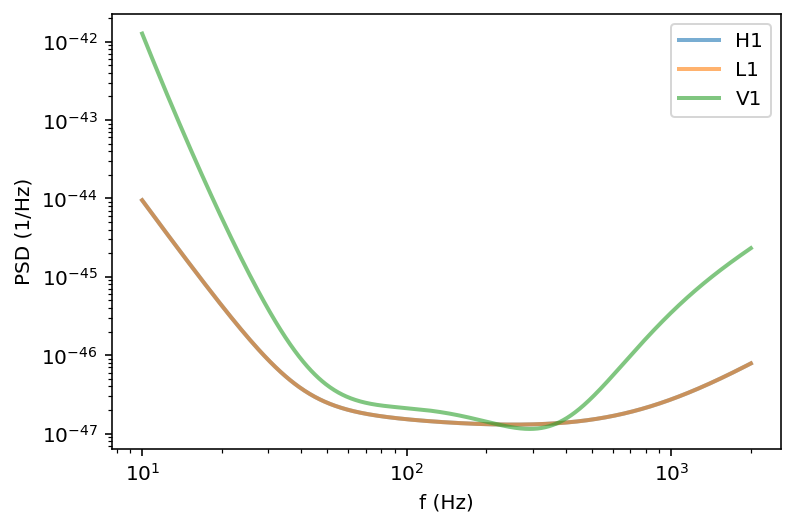

In [10]:
fs = np.linspace(10, 2e3, 4096)
for ifo, psd in psd_func_dict.items():
    plt.loglog(fs, np.vectorize(psd)(fs), label=ifo, alpha=0.6, lw=2)
plt.xlabel('f (Hz)')
plt.ylabel('PSD (1/Hz)')
plt.legend()
plt.show()

In [12]:
# define center of time array
tgps_geo = 1126259462.423

# define sampling rate and duration
fsamp = 8192
duration = 4

delta_t = 1/fsamp
tlen = int(round(duration / delta_t))

epoch = tgps_geo - 0.5*tlen*delta_t

time_dict = {i: np.arange(tlen)*delta_t + epoch for i in ifos}

In [13]:
freqs = np.fft.rfftfreq(tlen, delta_t)
delta_f = freqs[1] - freqs[0]

In [14]:
# we will want to pad low frequencies; the function below applies a
# prescription to do so smoothly, but this is not really needed: you
# could just set all values below `fmin` to a constant.
fmin = 30
def pad_low_freqs(f, psd_ref):
    return psd_ref + psd_ref*(fmin-f)*np.exp(-(fmin-f))/3

psd_dict = {}
for ifo in ifos:
    psd = np.zeros(len(freqs))
    for i,f in enumerate(freqs):
        if f >= fmin:
            psd[i] = psd_func_dict[ifo](f)
        else:
            psd[i] = pad_low_freqs(f, psd_func_dict[ifo](fmin))
    psd_dict[ifo] = psd

In [15]:
rng = np.random.default_rng(12345)

noise_fd_dict = {}
for ifo, psd in psd_dict.items():
    var = psd / (4.*delta_f)  # this is the variance of LIGO noise given the definition of the likelihood function
    noise_real = rng.normal(size=len(psd), loc=0, scale=np.sqrt(var))
    noise_imag = rng.normal(size=len(psd), loc=0, scale=np.sqrt(var))
    noise_fd_dict[ifo] = noise_real + 1j*noise_imag

In [16]:
print(delta_f)

0.25


/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


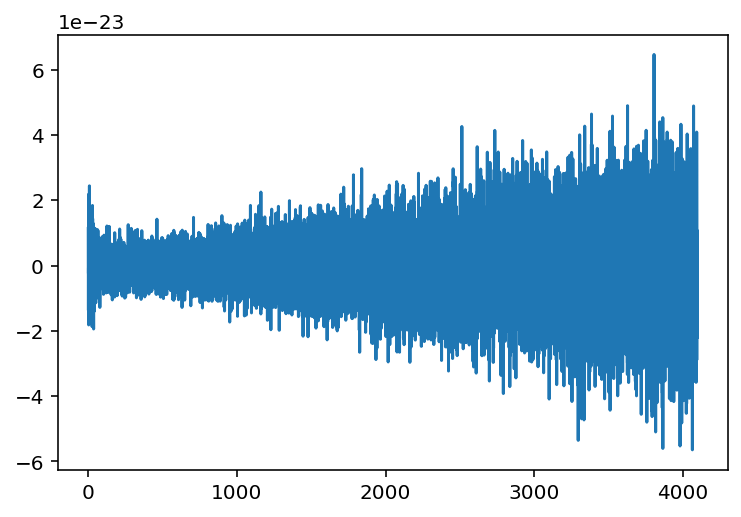

In [17]:
# So now lets look at the noise we have generated in H1. Looks good to me!
plt.plot(freqs, noise_fd_dict["H1"])

### Now lets generate a waveform and add them together

In [34]:
# Now lets compute the waveform ripple
m1 = 50.0
m2 = 10.0
Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))
chi1 = 0.4
chi2 = -0.3
D = 2000.0
tc = 2.0
phic = 0.0

f_list = freqs[freqs>fmin]
params = jnp.array([Mc, eta, chi1, chi2, D, tc, phic])
hp = gen_IMRPhenomD(f_list, params)

/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


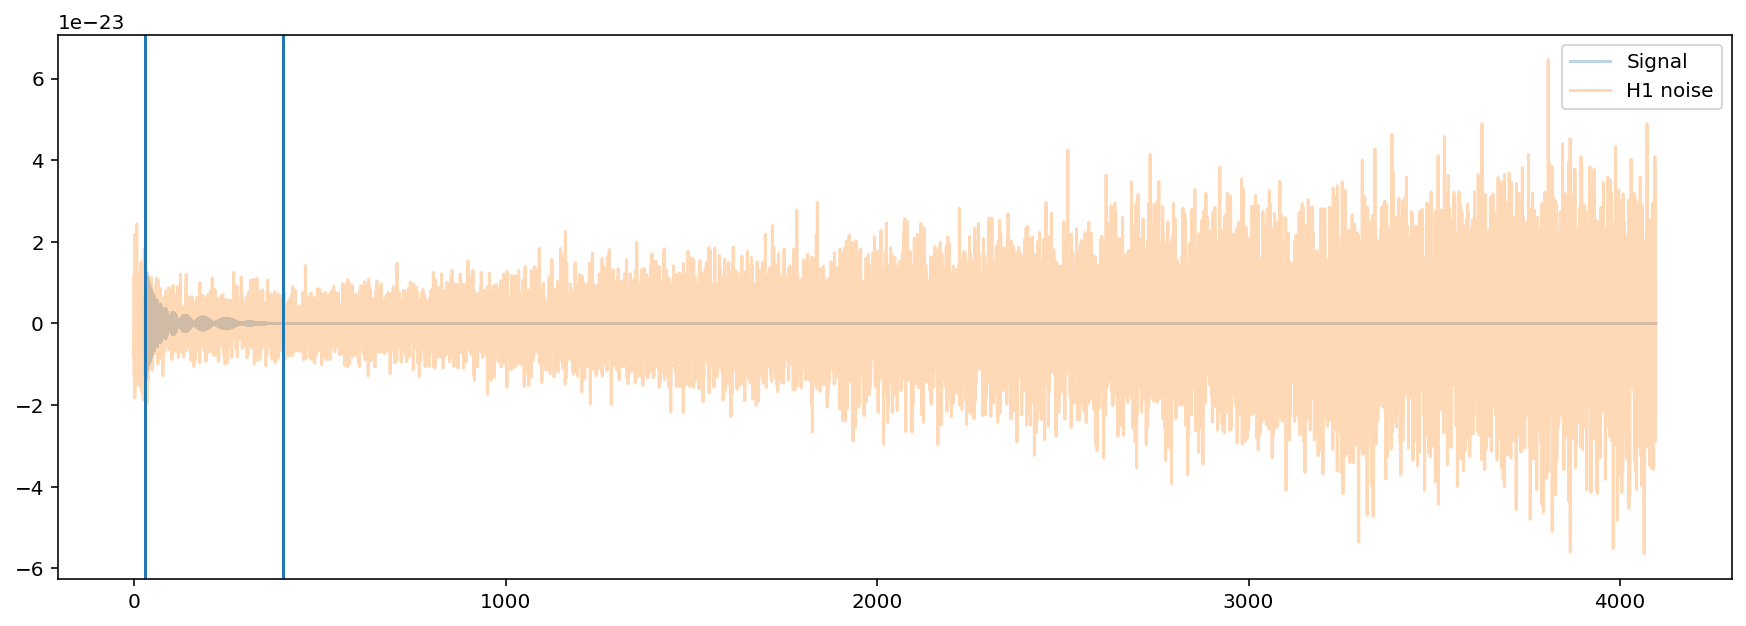

In [35]:
plt.figure(figsize=(15,5))
plt.plot(f_list, hp, label="Signal", alpha=0.3)
plt.plot(freqs, noise_fd_dict["H1"], label="H1 noise", alpha=0.3)
plt.axvline(30)
plt.axvline(400)
# plt.xlim(30, 31)
plt.legend()
plt.show()

In [36]:
# Note that I'm only using frequencies above 10 Hz since the waveform generation is not 
# reliable below this
data = noise_fd_dict["H1"][freqs>fmin] + hp
var = psd_dict["H1"] / (4.*delta_f)
sigma_list = np.sqrt(var[freqs>fmin])

### Finally, lets set up a numpyro MCMC

In [37]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value

prior_sigma_Mc = 5.0
prior_sigma_eta = 0.1
prior_sigma_chi = 5.0
prior_sigma_D = 10.0

prior_sigma_tc = 0.1
prior_sigma_phic = np.pi


def numpyro_likelihood(f, sigma, y=None):
    # Parameters of the model
    log_Mc = numpyro.sample("log_Mc", dist.Normal(np.log(Mc), prior_sigma_Mc))
    eta_ = numpyro.sample("eta", dist.Uniform(0.0, 0.25))
    
    chi1_ = numpyro.sample("chi1", dist.Uniform(-1., 1.))
    chi2_ = numpyro.sample("chi2", dist.Uniform(-1., 1.))
    
    log_D = numpyro.sample("log_D", dist.Normal(np.log(D), prior_sigma_D))
    
    tc_ = numpyro.sample("tc", dist.Uniform(tc-prior_sigma_tc, tc+prior_sigma_tc))
    
    phi_param = numpyro.sample("phi_param", dist.Normal(0., 1.0), sample_shape=(2,))
    phic_ = numpyro.deterministic("phic", 0.5 * jnp.arctan2(phi_param[1], phi_param[0]))
#     phic_ = numpyro.sample("phic", dist.Normal(phic, prior_sigma_phic))
    
    # This is the part I'm not sure I understand...
    # I'm not sure which part should be data and which part is 
    params = jnp.array([jnp.exp(log_Mc), eta_, chi1_, chi2_, jnp.exp(log_D), tc_, phic_])
    waveform = gen_IMRPhenomD(f, params)
    
    # Likelihood definition
    numpyro.sample(
        "real_obs", dist.Normal(waveform.real, sigma), obs=None if y is None else y.real
    )
    numpyro.sample(
        "imag_obs", dist.Normal(waveform.imag, sigma), obs=None if y is None else y.imag
    )

In [38]:
print(f_list[:1500])

[ 30.25  30.5   30.75 ... 404.5  404.75 405.  ]


In [39]:
init = {
    "log_Mc": np.log(Mc),
    "eta": eta,
    "chi1": chi1,
    "chi2": chi2,
    "log_D": np.log(D),
    "tc": tc,
    "phi_param": np.array([np.cos(phic), np.sin(phic)]),
}
nuts_kernel = NUTS(
    numpyro_likelihood, dense_mass=True, target_accept_prob=0.9,
    init_strategy=init_to_value(values=init)
)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=1000,
    num_chains=2,
    progress_bar=True,
)
rng_key = jax.random.PRNGKey(34923)

mcmc.run(rng_key, f_list[:1500], sigma_list[:1500], y=data[:1500])
samples = mcmc.get_samples()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

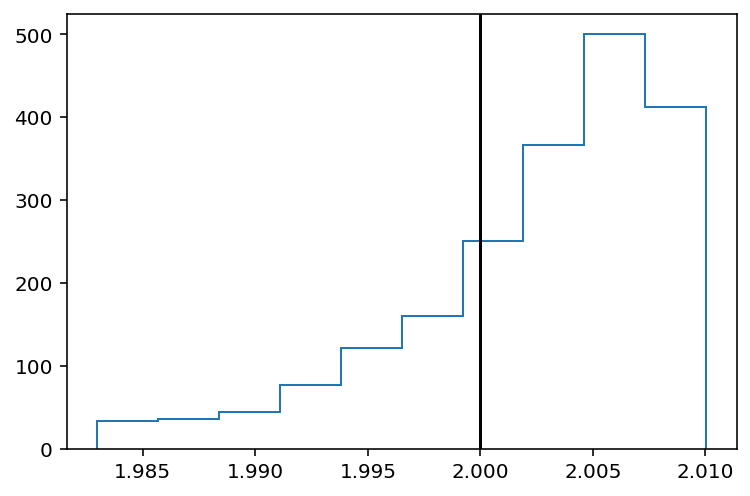

In [40]:
plt.hist(np.array(samples["tc"]), histtype="step")
plt.axvline(tc, color="k");

In [41]:
trace = az.from_numpyro(mcmc)
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
chi1,0.422,0.061,0.302,0.521,0.005,0.004,132.0,99.0,1.02
chi2,-0.489,0.413,-1.000,0.301,0.034,0.024,116.0,117.0,1.03
eta,0.136,0.006,0.125,0.148,0.000,0.000,299.0,404.0,1.01
log_D,7.612,0.047,7.525,7.697,0.002,0.001,530.0,806.0,1.01
log_Mc,2.905,0.014,2.878,2.928,0.001,0.001,266.0,388.0,1.01
phi_param[0],0.006,0.967,-1.773,1.890,0.042,0.030,538.0,530.0,1.00
phi_param[1],-0.062,0.988,-1.921,1.804,0.058,0.041,291.0,658.0,1.01
phic,-0.119,0.889,-1.516,1.341,0.063,0.045,190.0,367.0,1.00
tc,2.002,0.006,1.991,2.010,0.000,0.000,118.0,117.0,1.03


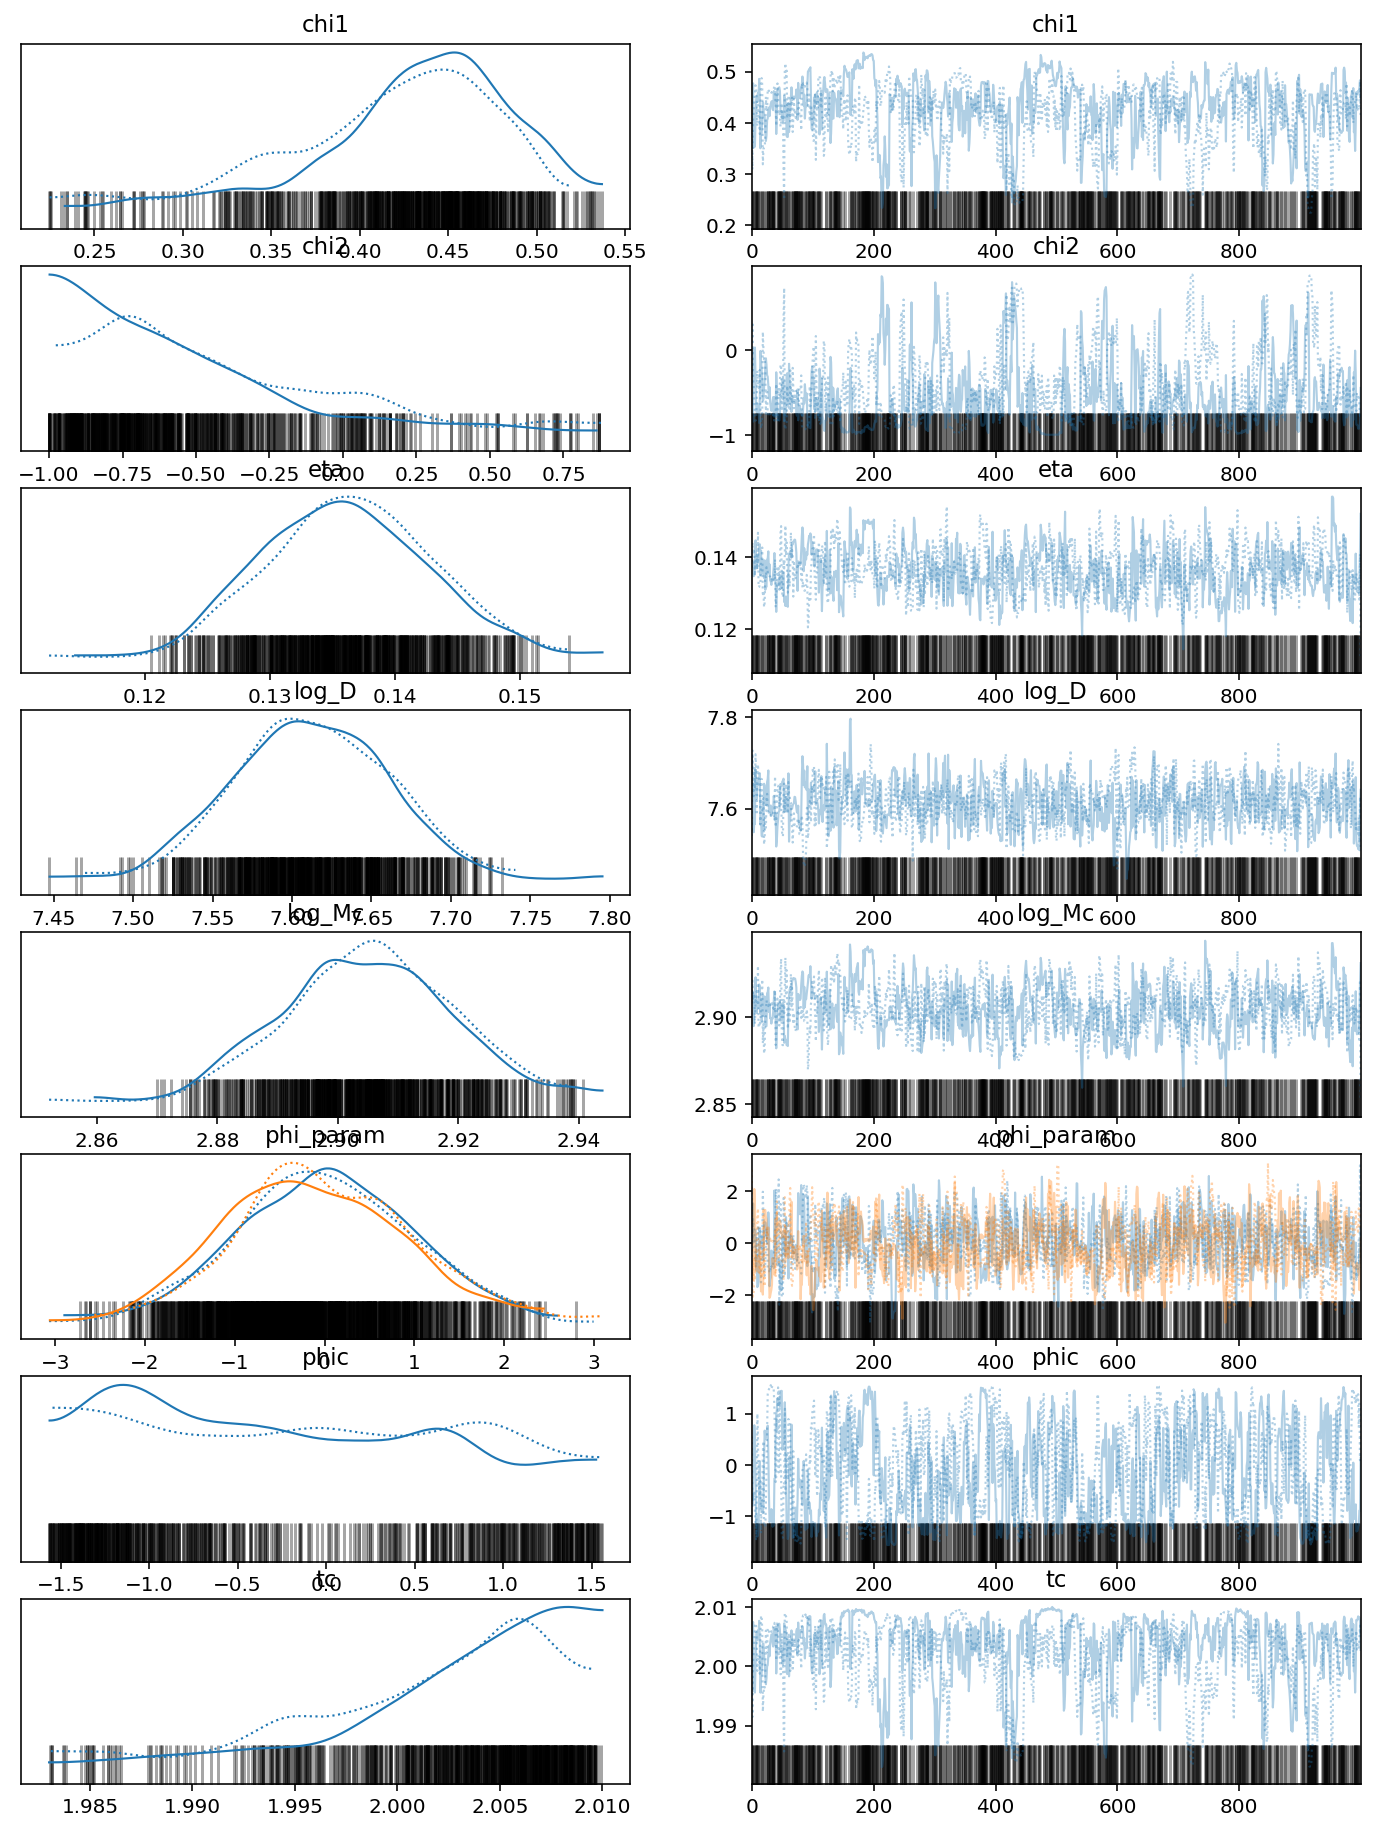

In [42]:
az.plot_trace(trace);

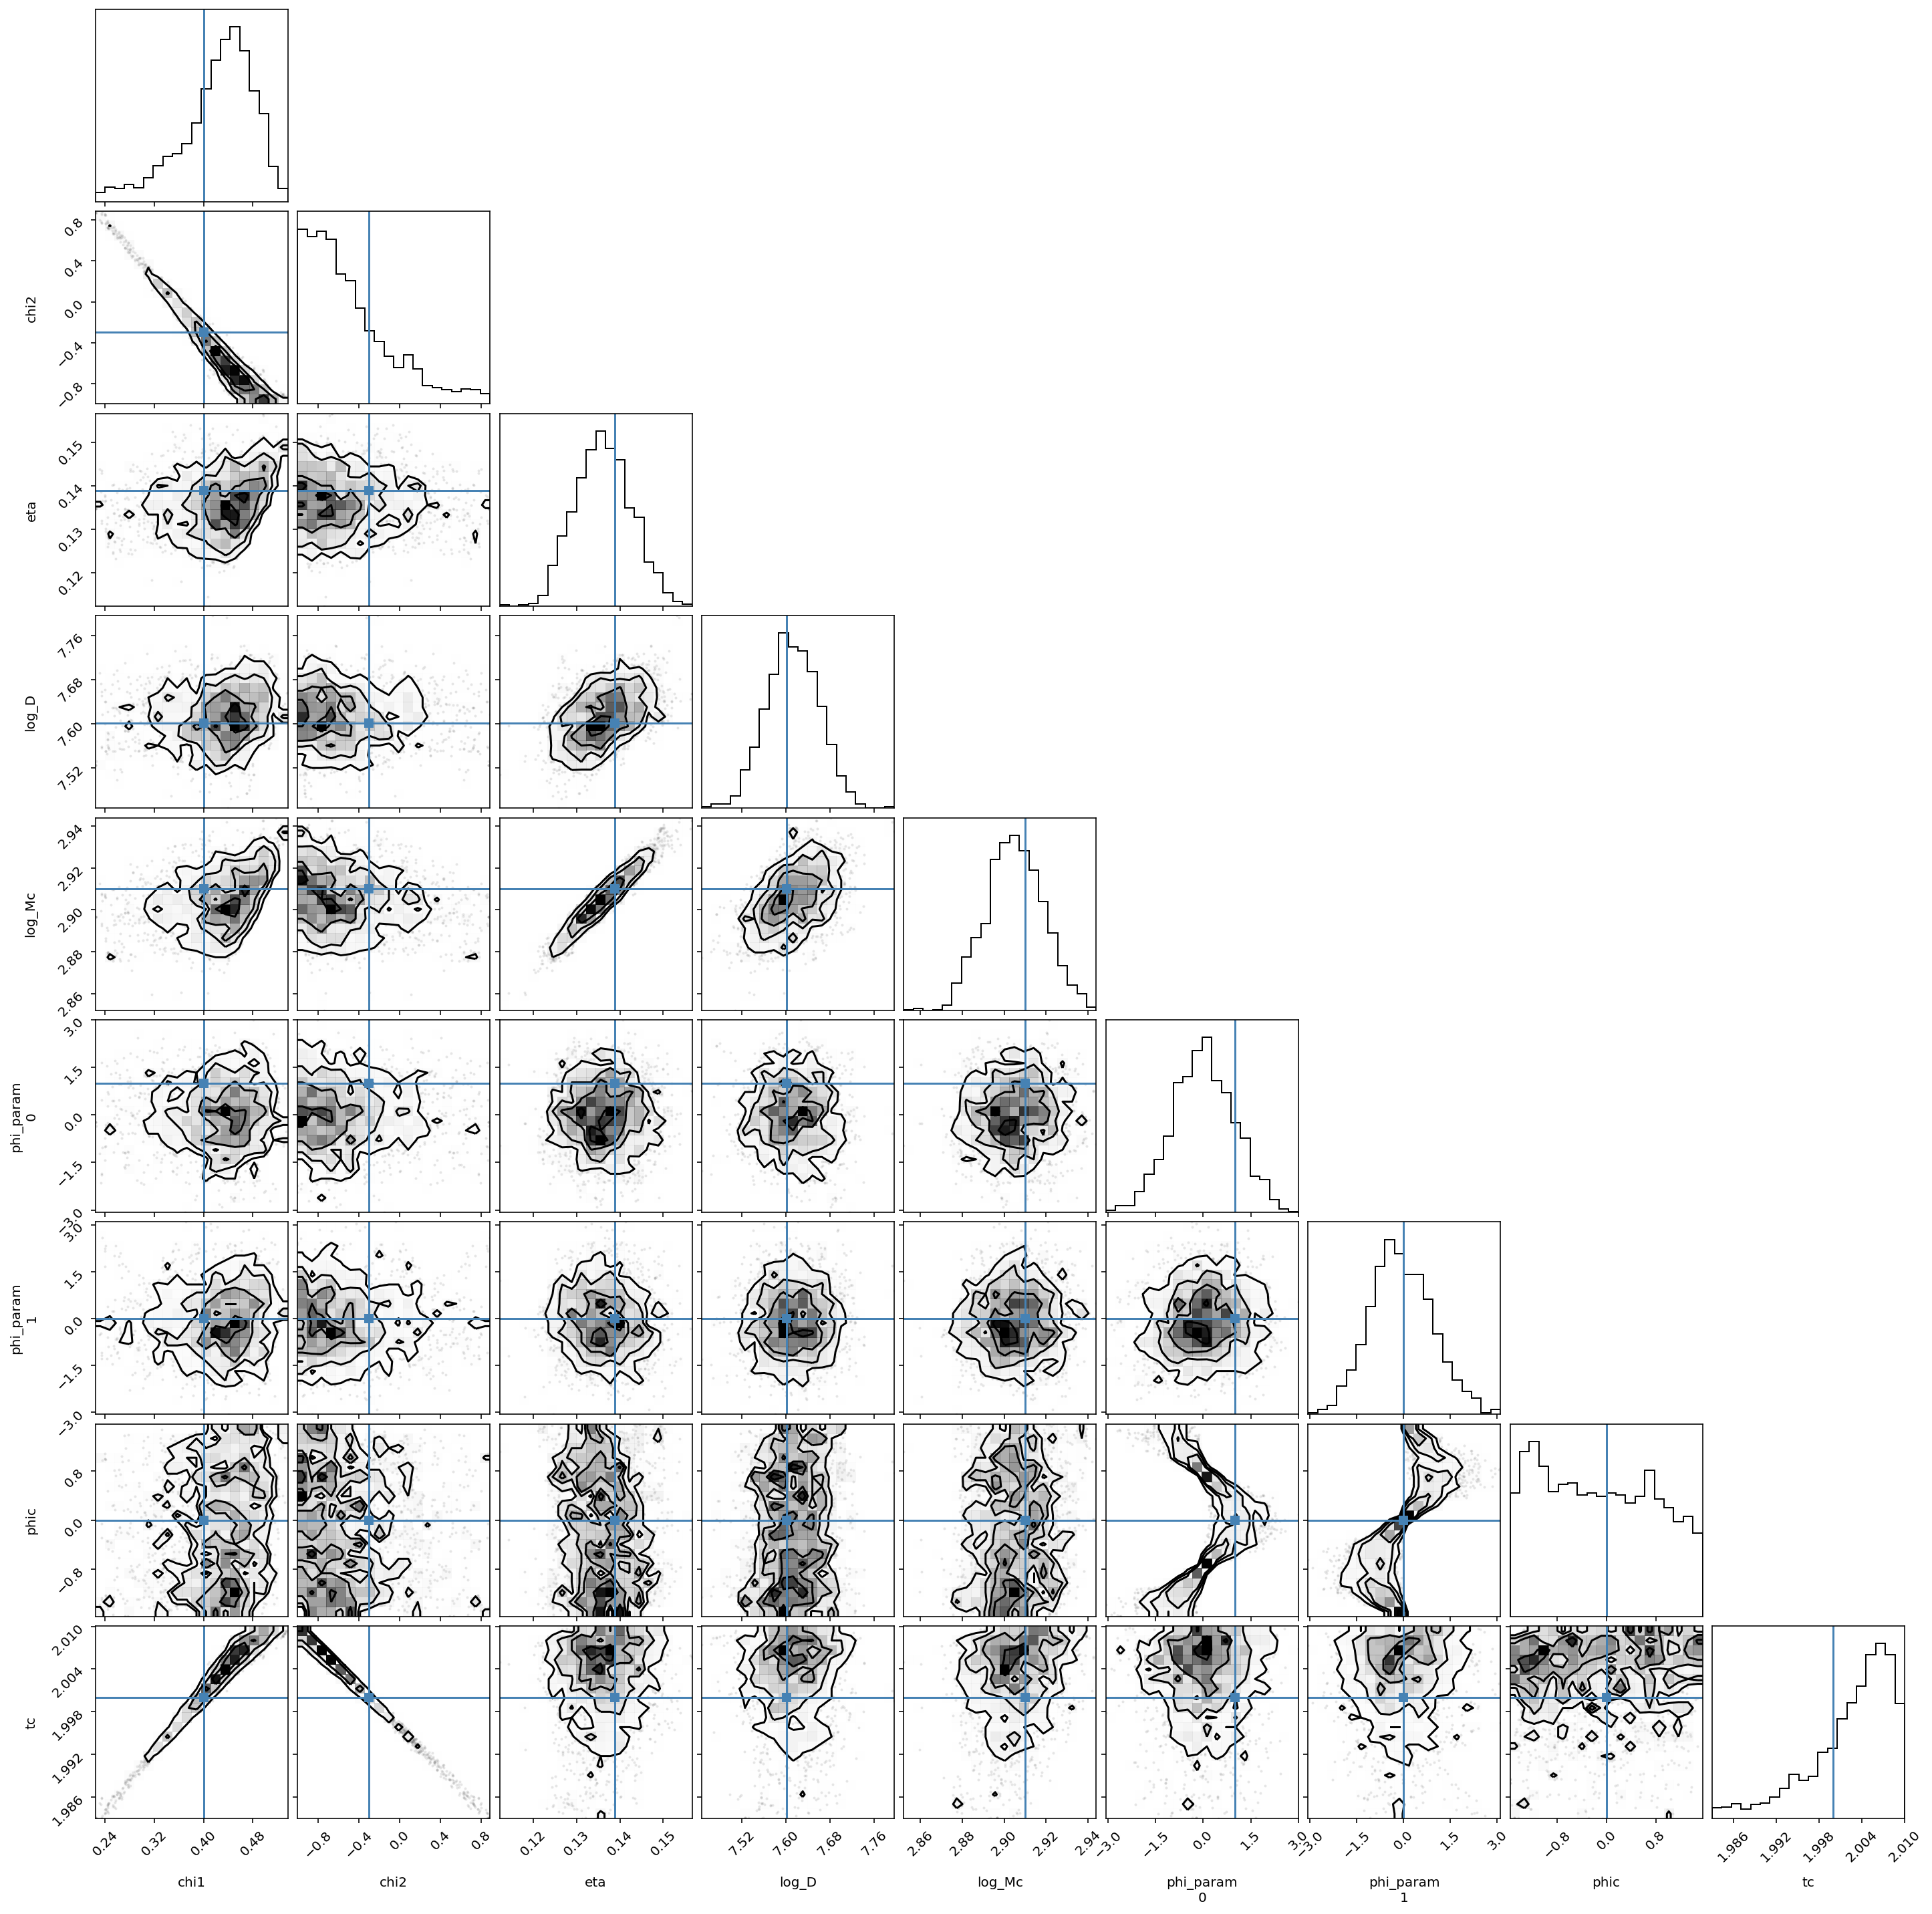

In [43]:
init["phic"] = phic
corner.corner(trace, truths=init);

In [44]:
a = trace.posterior["chi1"].values.flatten()
b = trace.posterior["chi2"].values.flatten()
from ripple import Mc_eta_to_ms

m1, m2 = Mc_eta_to_ms(np.array([np.exp(trace.posterior["log_Mc"].values.flatten()), trace.posterior["eta"].values.flatten()]))
print(m1, m2)

[50.14665049 50.12167993 50.39012379 ... 52.20853822 50.01236511
 56.03708017] [10.07247859 10.04976317 10.01980474 ...  9.27563786 10.20513678
  8.29211315]


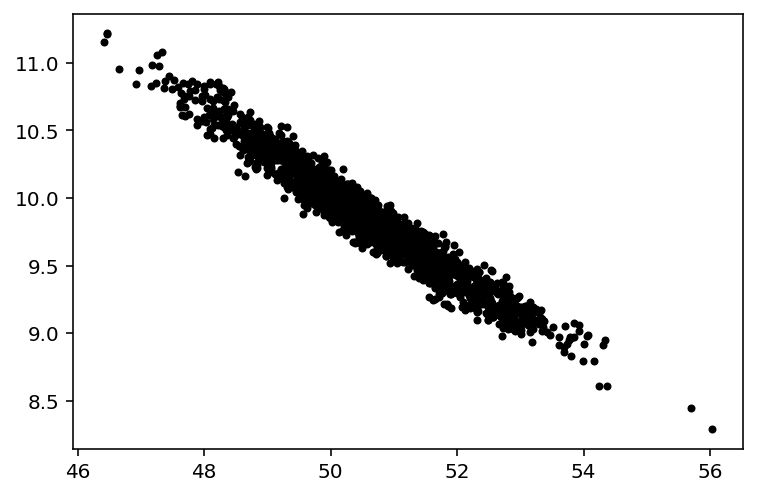

In [45]:
plt.plot(m1, m2, ".k");

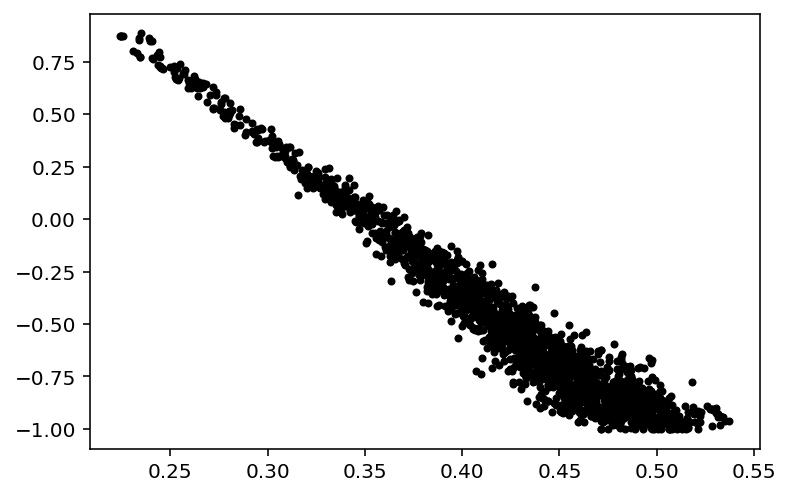

In [46]:
plt.plot(a, b, ".k");

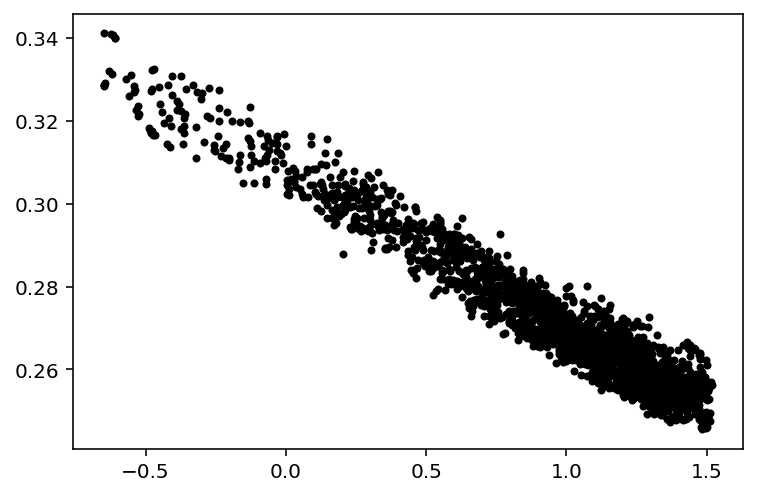

In [47]:
plt.plot(a - b, (m1 * a + m2 * b) / (m1 + m2), ".k");

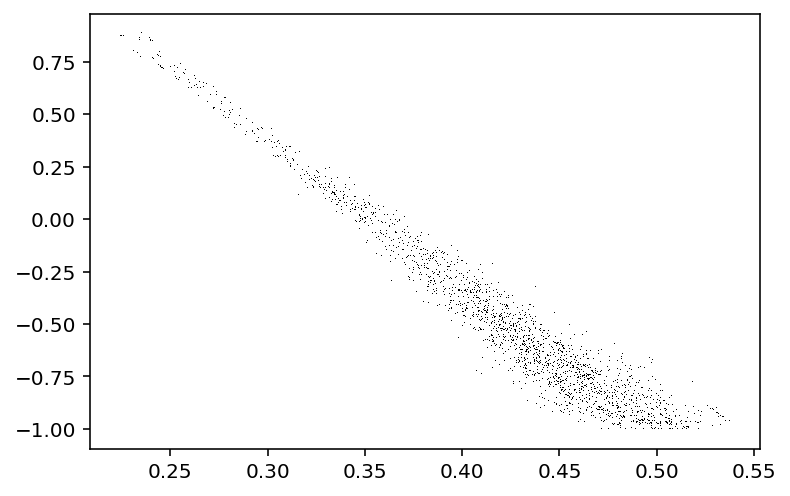

In [48]:
plt.plot(a, b, ",k");